In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import simulation_utils as su
import importlib

In [53]:
# Define some parameters

w0 = 55000*2*np.pi # Natural frequency of oscillator
P = 1*10**(-7) # Pressure in mbar
T = 2000 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)

Snn = 10**(-24) # Displacement noise

0.0007764032293363121


In [54]:
maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
yfb = 1*2*np.pi
numbins = int(2*5*10**4*100*2*np.pi/yfb)*1 # This is to ensure the particle amplitude decays to thermal levels
w = np.linspace(0, maxw*2*np.pi, numbins)

# Generate some random number seeds
np.random.seed(85655219)
random_nums = np.random.uniform(0, 1000000, 3) # These are the seeds we will use

randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[0:3], Snn, numbins, maxw)
x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, np.zeros(numbins))
x = x+10**(-5)*np.sin(100*2*np.pi*np.linspace(0, 10, 10**7))

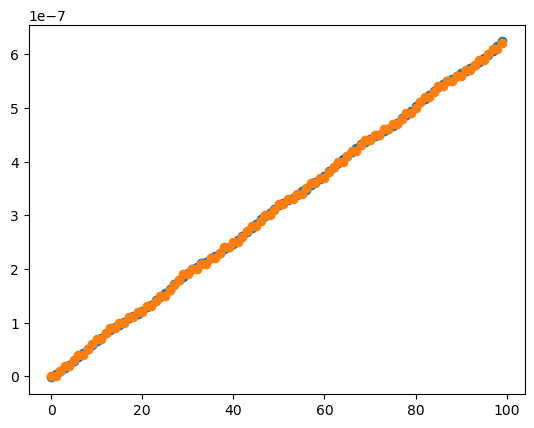

In [55]:
plt.plot(x[:100], 'o')
plt.plot([round(i, 8) for i in x[:100]], 'o')

In [56]:
x2 = np.array([round(i, 8) for i in x])
PSDx = scisig.welch(x, fs = 10**6, nperseg = 10**4, window = 'boxcar')
PSDx2 = scisig.welch(x2, fs = 10**6, nperseg = 10**4, window = 'boxcar')

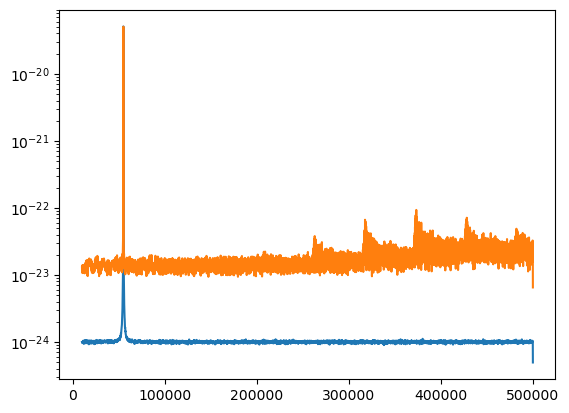

In [57]:
plt.plot(PSDx[0][100:], PSDx[1][100:])
plt.plot(PSDx2[0][100:], PSDx2[1][100:])
plt.yscale('log')

In [44]:
PSD = scisig.welch(x, fs = 10**6, nperseg = 10**4, window = 'boxcar')

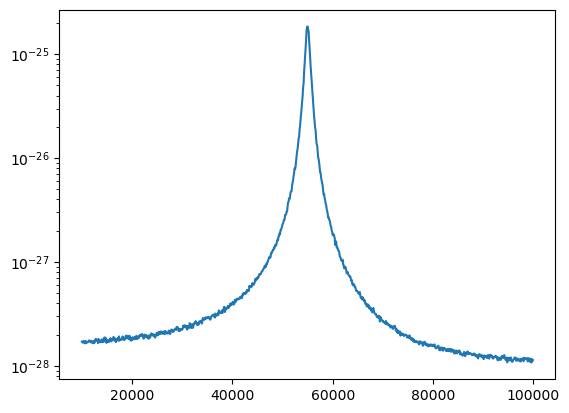

In [23]:
lb = int(0.01*10000)
ub = int(0.01*100000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')

In [74]:
x_ff = au.butter_bandpass_filter(x, 1000, 100000, fs = 10**6, order = 5)
R = np.sqrt(x_ff**2)
R_ff = au.butter_lowpass_filter(R, 50000, fs = 10**6, order = 5)
PSDR = scisig.welch(R_ff, fs = 10**6, nperseg = 10**4, window = 'boxcar')
time = np.linspace(0, len(x)/10**6, len(x))
recon = R*np.sin(2*np.pi*55000*time)
PSD_recon = scisig.welch(recon, fs = 10**6, nperseg = 10**4, window = 'boxcar')

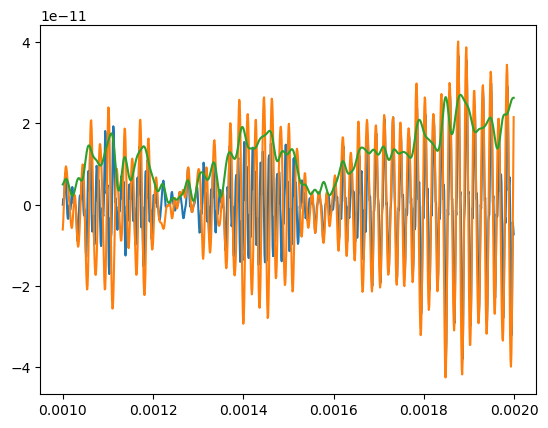

In [75]:

lb = 1000
ub = 2000
plt.plot(time[lb:ub], recon[lb:ub])
plt.plot(time[lb:ub], x_ff[lb:ub])
plt.plot(time[lb:ub], R_ff[lb:ub])

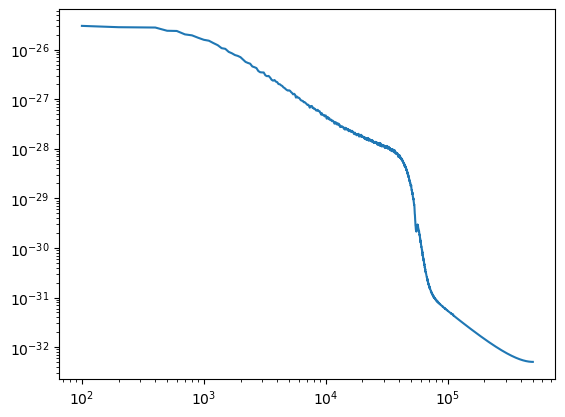

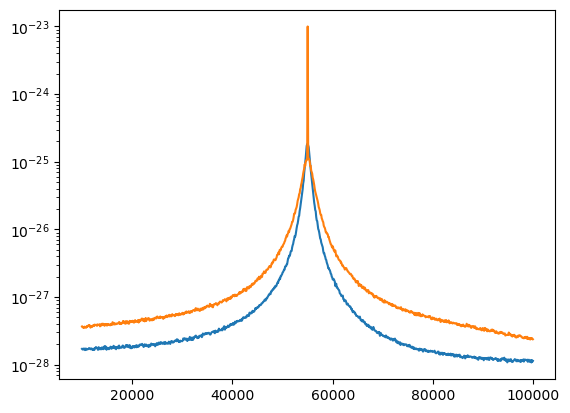

In [76]:
lb = int(1)
ub = int(0.01*500000)
plt.plot(PSDR[0][lb:ub], PSDR[1][lb:ub])
plt.yscale('log')
plt.xscale('log')
plt.figure()
lb = int(0.01*10000)
ub = int(0.01*100000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.plot(PSD[0][lb:ub], PSD_recon[1][lb:ub]*10)
plt.yscale('log')

In [148]:
time, R2, R2_filt, theta_filt = au.lockin(x[0][:10**7], 10**6, 55000, 54000, 100000, 1000, 'R')

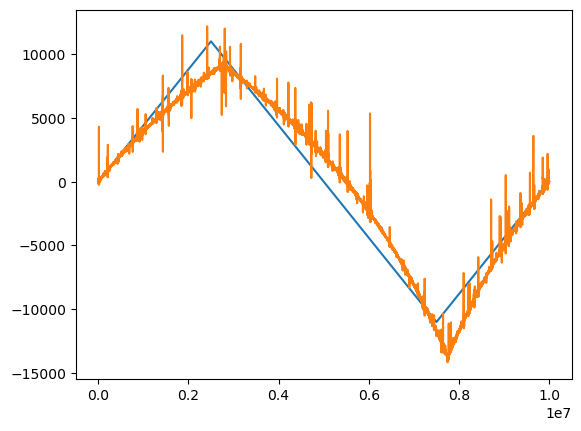

In [149]:
lb = 0
ub = -1
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.2, 0.25)
plt.plot(mod*55000-55000)
plt.plot(np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi)

In [150]:
PSDR2 = scisig.welch(R2[:5*10**6], fs = 10**6, nperseg = 10**6, window = 'boxcar')
PSDR22 = scisig.welch(R2[5*10**6:], fs = 10**6, nperseg = 10**6, window = 'boxcar')

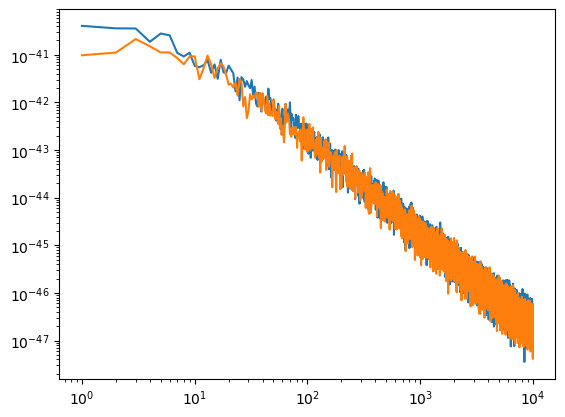

In [151]:
plt.plot(PSDR2[0][1:10000], PSDR2[1][1:10000])
plt.plot(PSDR22[0][1:10000], PSDR22[1][1:10000])
plt.yscale('log')
plt.xscale('log')

In [31]:
w_est = np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi/55000+1

In [32]:
theta_est = []
area = 0
for i in range(len(w_est)):
    area += np.trapz(w_est[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    theta_est.append(area)

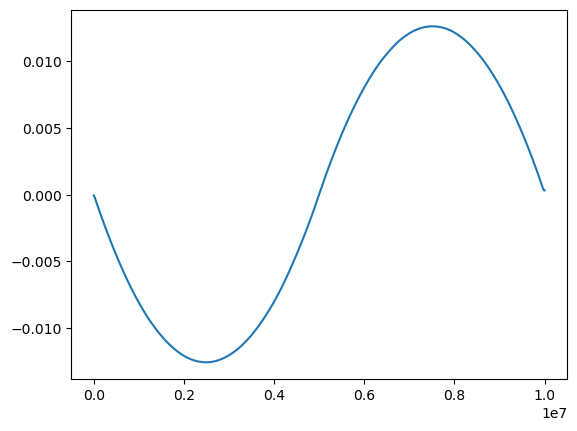

In [85]:
#plt.plot(np.array(theta_est)*2*np.pi*55000)
plt.plot(theta_filt/2/np.pi/55000)

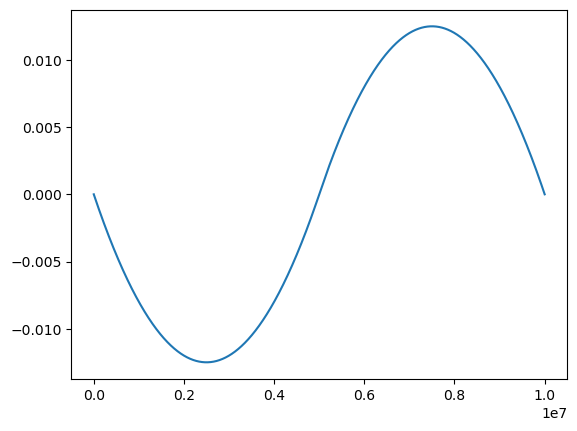

In [83]:
plt.plot(x[2]-x[1])

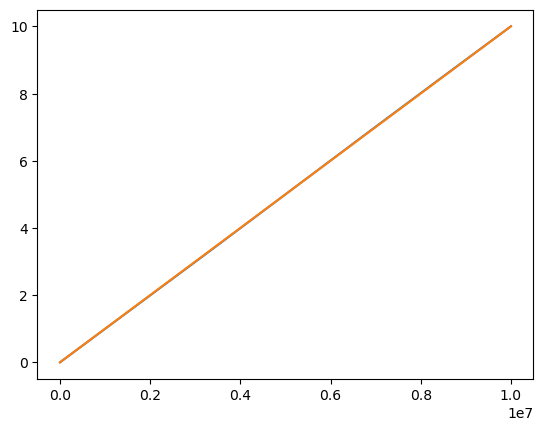

In [87]:
time = np.linspace(1*10**(-6), 10, 10**7-1)
plt.plot((theta_filt/2/np.pi/55000)+time)
plt.plot(time)

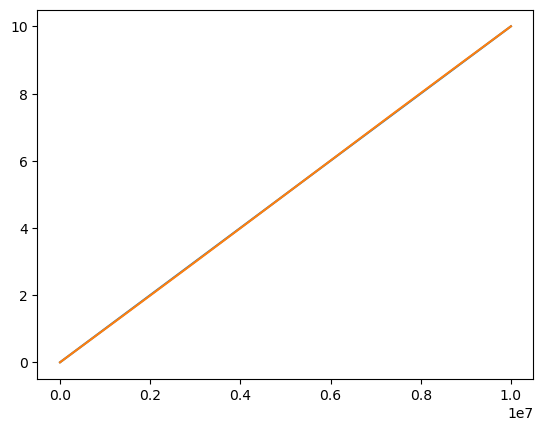

In [78]:
plt.plot(x[1])
plt.plot(x[2])

In [46]:
len(x[0])
len(x[1])

10000000

In [71]:
theta_est

[1.990140770662846e-06,
 3.980281207547027e-06,
 5.970421199392576e-06,
 7.96056074619887e-06,
 9.950699847965285e-06,
 1.1940838504691202e-05,
 1.3930976716376018e-05,
 1.5921114483019136e-05,
 1.7911251804619936e-05,
 1.99013886811778e-05,
 2.189152511269214e-05,
 2.3881661099162363e-05,
 2.5871796640587858e-05,
 2.7861931736968015e-05,
 2.985206638830225e-05,
 3.184220059458997e-05,
 3.383233435583056e-05,
 3.5822467672023446e-05,
 3.781260054316803e-05,
 3.980273296926372e-05,
 4.179286495030993e-05,
 4.378299648630609e-05,
 4.5773127577251616e-05,
 4.776325822314592e-05,
 4.975338842398843e-05,
 5.174351817977856e-05,
 5.3733647490515735e-05,
 5.572377635619938e-05,
 5.771390477682891e-05,
 5.9704032752403765e-05,
 6.169416028292336e-05,
 6.368428736838712e-05,
 6.567441400879449e-05,
 6.766454020414489e-05,
 6.965466595443778e-05,
 7.164479125967258e-05,
 7.363491611984874e-05,
 7.562504053496576e-05,
 7.761516450502304e-05,
 7.960528803002005e-05,
 8.159541110995621e-05,
 8.3585

In [88]:
x_mod = su.frequency_modulation(x[0], x[2], x[1])
x_mod2 = su.frequency_modulation(x[0], (theta_filt/2/np.pi/55000)+time, x[1])

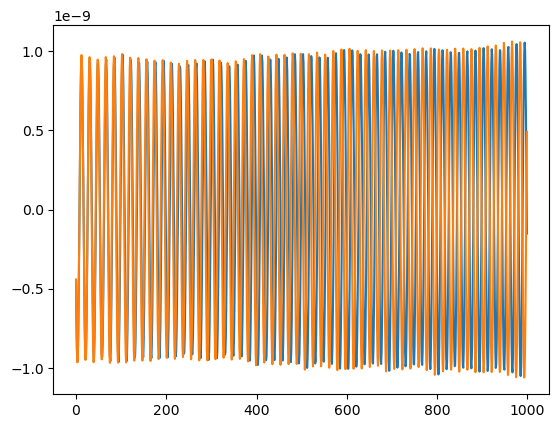

In [80]:
plt.plot(x_mod[:1000])
plt.plot(x[0][:1000])

In [89]:
PSD_mod = scisig.welch(x_mod, fs = 10**6, nperseg = 10**6, window = 'boxcar')
PSD_mod2 = scisig.welch(x_mod2, fs = 10**6, nperseg = 10**6, window = 'boxcar')

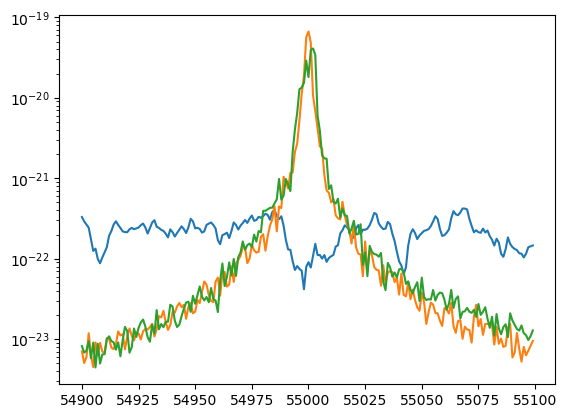

In [92]:
lb = int(1*54900)
ub = int(1*55100)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.plot(PSD_mod[0][lb:ub], PSD_mod[1][lb:ub])
plt.plot(PSD_mod2[0][lb:ub], PSD_mod2[1][lb:ub])
plt.yscale('log')

In [52]:
time2 = su.generate_sawtooth_frequency_modulation(np.linspace(0, 10, 10**7), 0.01, 0)
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.01, 0)

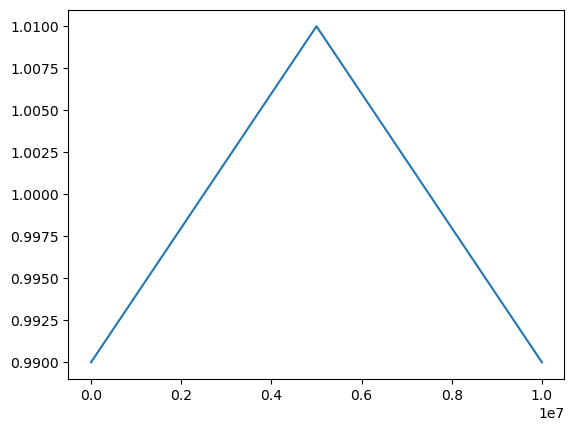

In [53]:
plt.plot(mod)

In [54]:
foo = []
area = 0
for i in range(len(mod)):
    area += np.trapz(mod[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    foo.append(area)

In [55]:
plt.plot(foo)

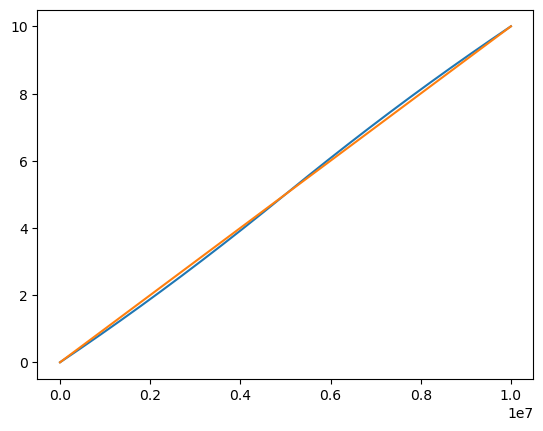

In [ ]:

plt.plot(np.array(foo)/2)
plt.plot(np.linspace(0, 10, 10**7))
#plt.plot(time2)

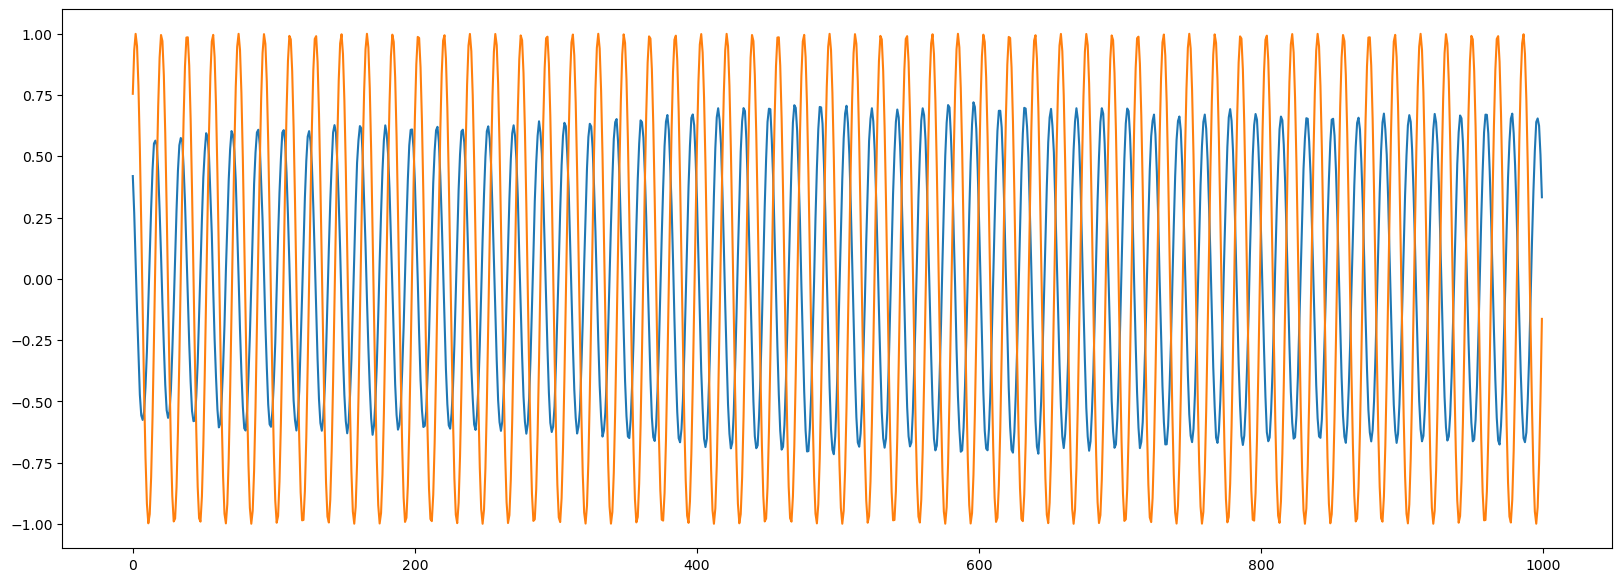

In [59]:
lb = -int(8*10**6)
ub = lb+1000 
plt.figure(figsize = (20, 7))
plt.plot(x[lb:ub]*10**9)
#plt.plot(np.sin((55000*2*np.pi+theta_filt[:-1]+(theta_filt[1:] - theta_filt[:-1])*10**6)*np.linspace(2*10**(-6), 10, 10**7-2))[lb:ub])
plt.plot(np.sin((55000*2*np.pi)*np.linspace(1*10**(-6), 10, 10**7-1)+theta_filt)[lb:ub])

In [100]:
np.std((theta_filt[1:] - theta_filt[:-1])*10**6/2/np.pi/2)

0.26801164045959797

c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


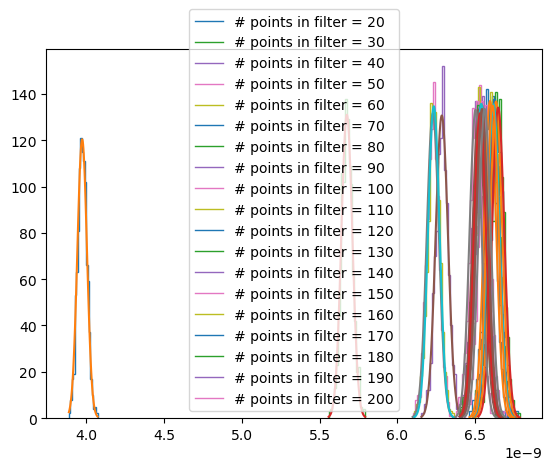

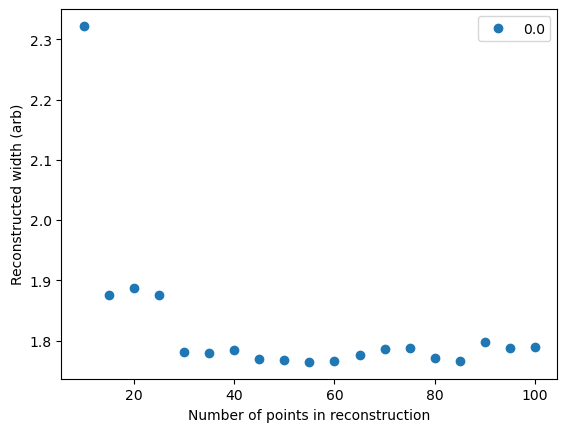

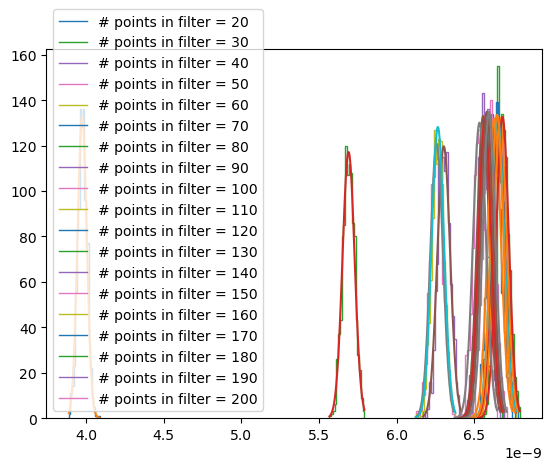

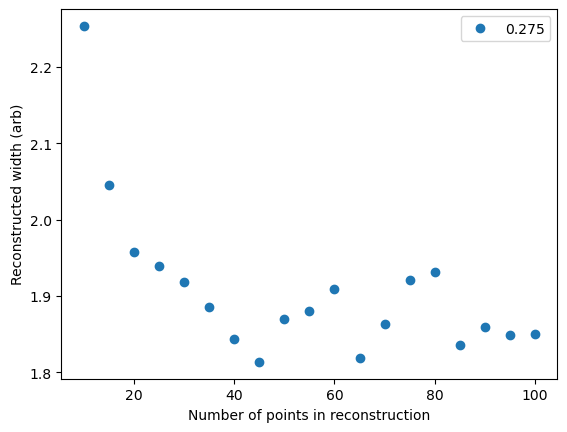

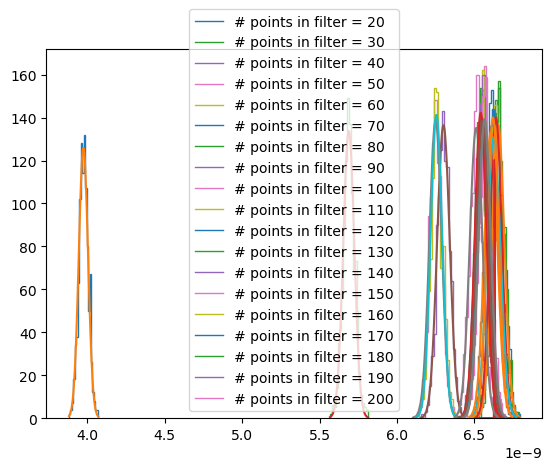

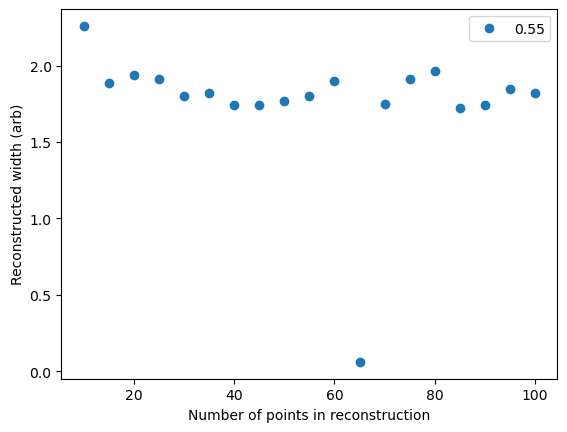

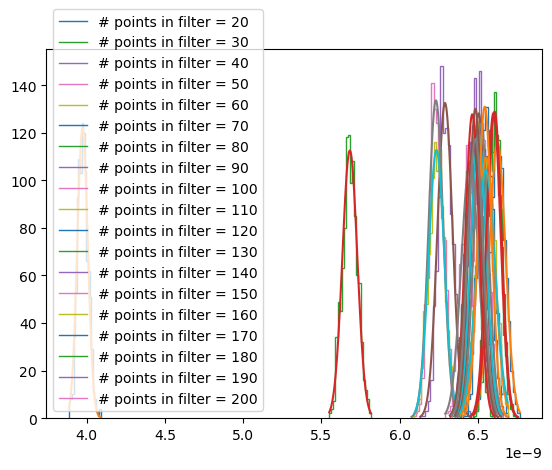

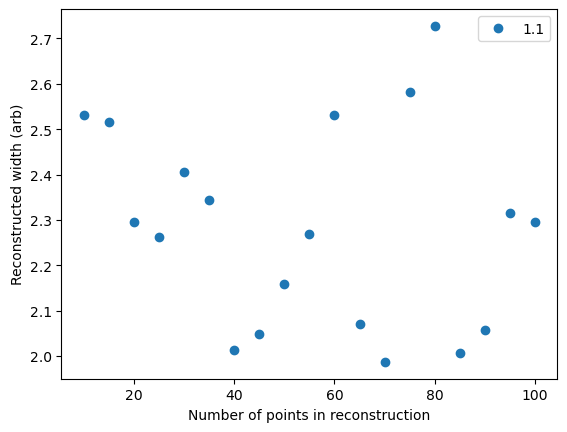

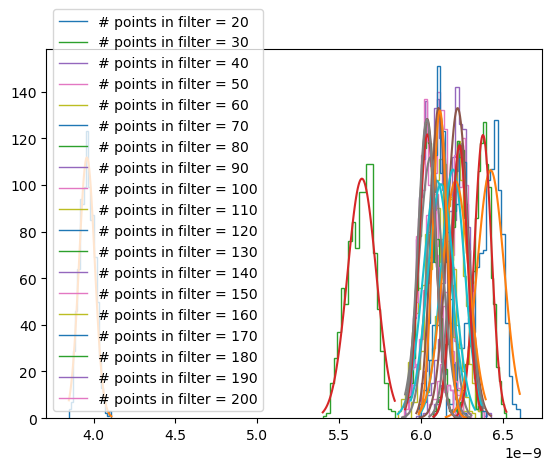

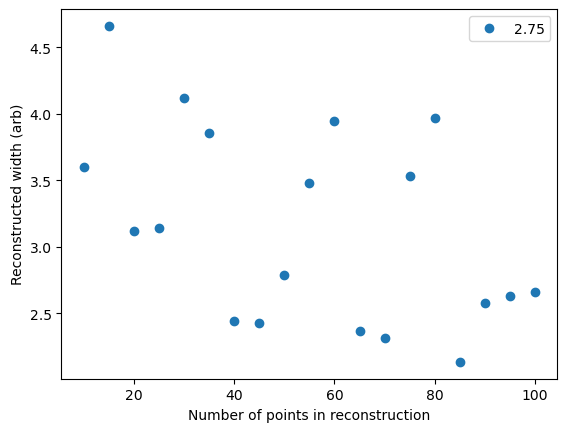

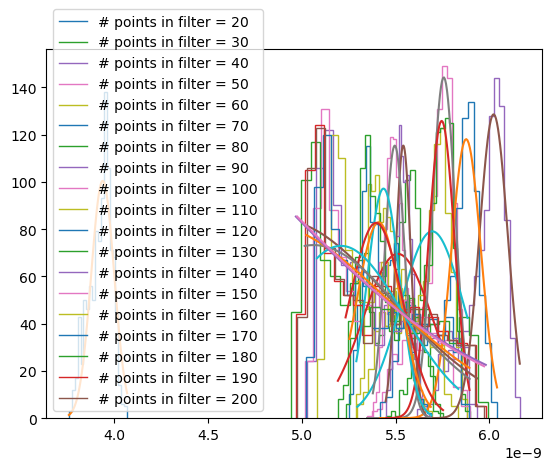

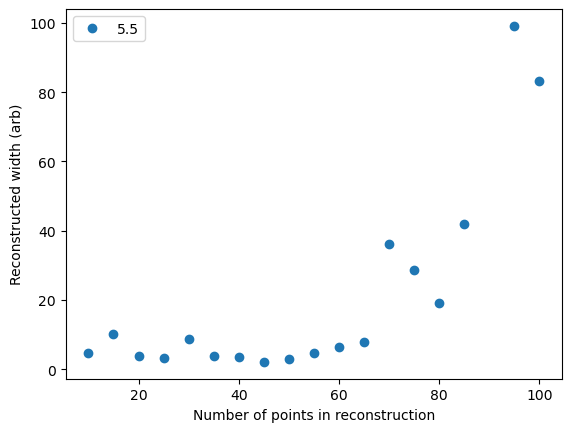

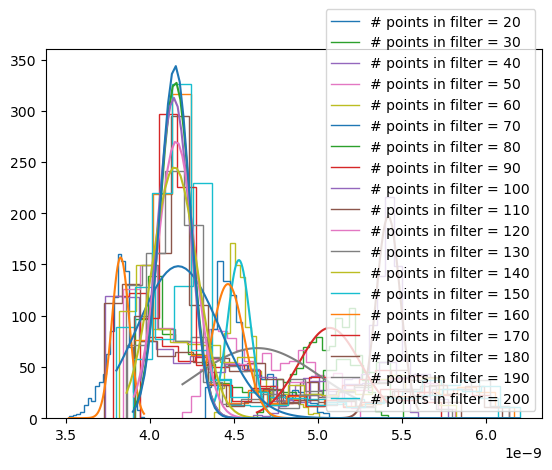

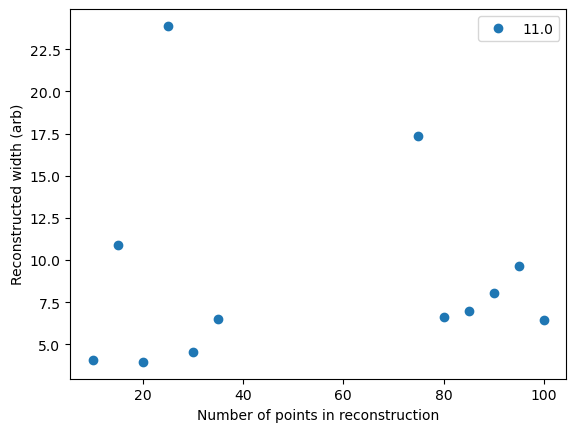

In [98]:
yfb_l = np.array([1000])*2*np.pi
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

filename1 ='D:/Simulation Data/240529/Frequency modulation/Short_template'

for yfb in yfb_l:
    for iter in iter_l:
        widths = np.zeros(len(bands))
        means = np.zeros(len(bands))
        plt.figure()
        for n, band in enumerate(bands):
            data = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter)  + '_' + str(band) +'.hdf5')
            corr_max = data['Kicks']
            try:
                hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
                means[n] = abs(fit[1])
                widths[n] = abs(fit[2])
                plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
                plt.plot(x_hist, fitted)
            except RuntimeError:
                hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
                means[n] = 'Nan'
                widths[n] = 'Nan'
                plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
        plt.legend()
        plt.figure()
        plt.plot(bands[:], widths*300/means, 'o', label = str(iter*55000/1000))
        plt.ylabel('Reconstructed width (arb)')
        plt.xlabel('Number of points in reconstruction')
        plt.legend()

In [83]:
fit

array([6.83109598e+01, 4.63966993e-09, 3.69479011e-10])